**SERVICIO EDUCACIONAL HOGAR Y SALUD DEL NORTE**

**INDICADOR: Pronostico de la demanda de materiales por sede**

Christian Ovalle

In [ ]:
!pip install --upgrade pip
!pip install pandas==2.2.2
!pip install numpy==1.25.2 # Downgrade numpy
!pip install scikit-learn==1.3.1 xgboost==1.6.1
!pip install scikit-learn==1.3.1 xgboost==1.6.1


**1. PREPARACIÓN DE LA DATA**

  En esta sección se preparan los datos necesarios para aplicar el modelo. Se realiza la instalación de bibliotecas, la lectura del archivo Excel, la transformación de los datos, la aplicación de técnicas pertinentes de preprocesamiento de datos y la separación de los datos en conjuntos de entrenamiento y prueba.

       Cantidad   año       campo  Suma de precio  dia  mes  \
0            57  2016   SEHS ANOP             210    1    1   
1             6  2016   SEHS APCE            1152    1    1   
2             3  2016   SEHS ANOP            1303    1    1   
3             6  2016  SEHS MICOP             110    1    1   
4            33  2016   SEHS APCE             230    1    1   
...         ...   ...         ...             ...  ...  ...   
60782        78  2023   SEHS APCE             224   30   12   
60783       184  2023  SEHS MICOP              90   30   12   
60784         6  2023  SEHS MICOP              32   30   12   
60785       110  2023   SEHS ANOP             177   30   12   
60786        85  2023  SEHS MICOP             130   30   12   

                   Categoria  Costos      fecha  
0             Titulos varios      61 2016-01-01  
1                    Biblias     331 2016-01-01  
2                    Biblias     395 2016-01-01  
3                    Biblias      30 2016-0

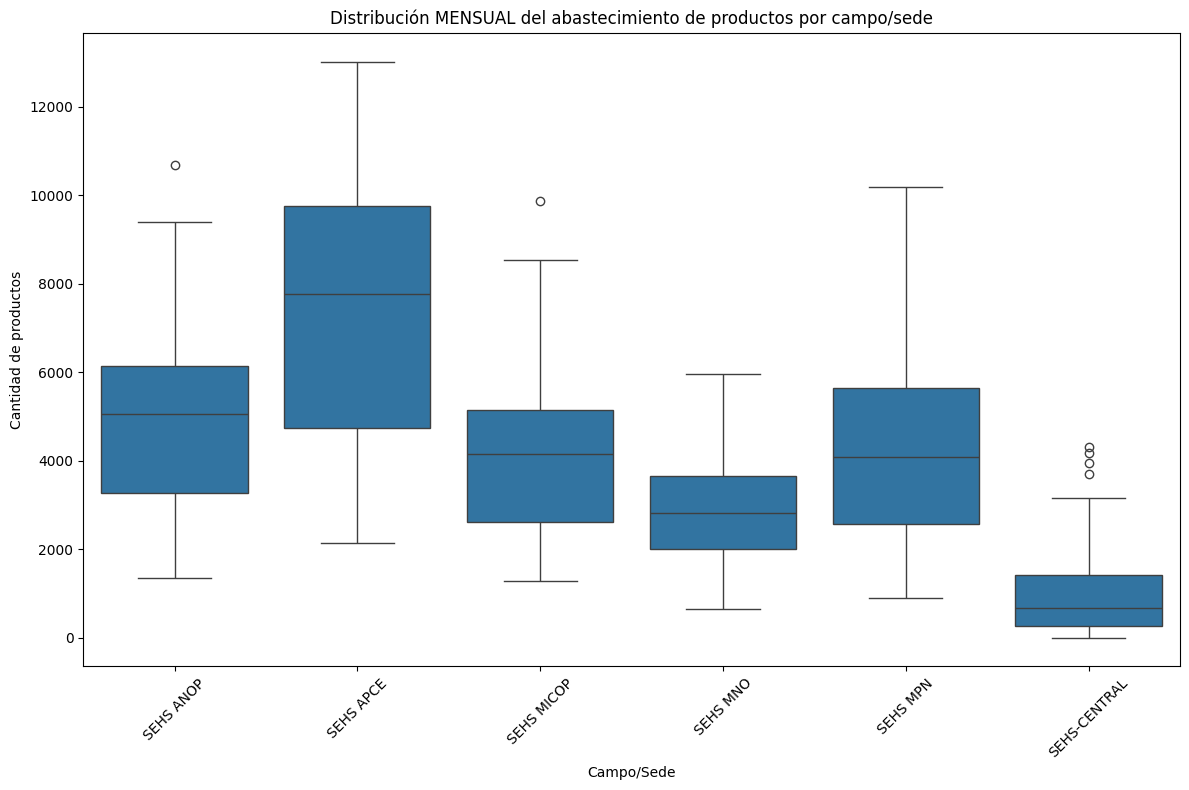

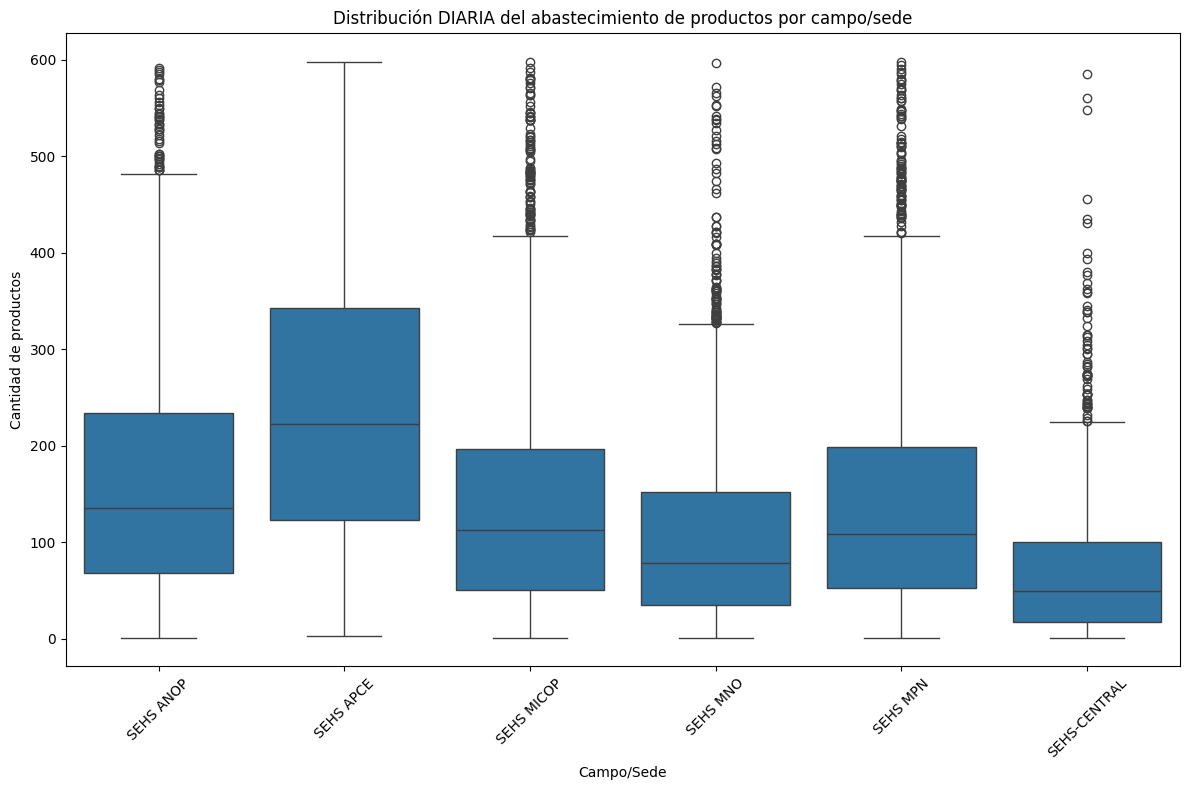

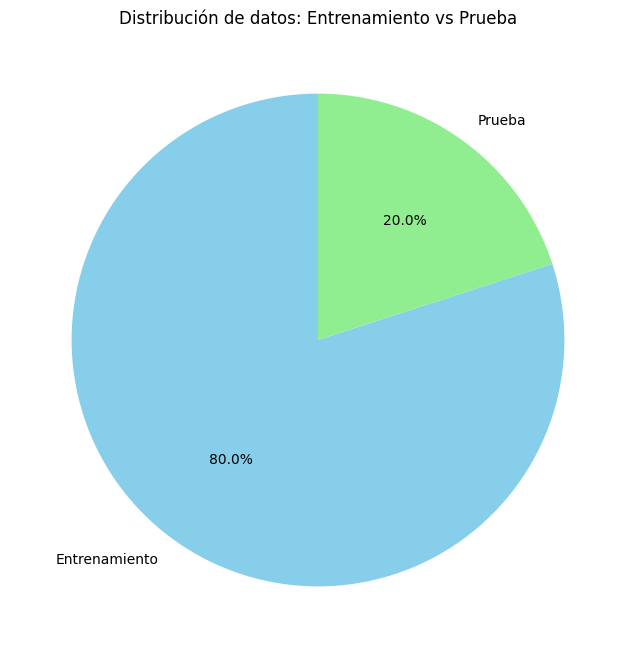

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import zscore

# Cargar el dataset
file_path = "/content/Datasets_Base_familias.xlsx"
dataset = pd.read_excel(file_path)
dataset = dataset.drop('Unnamed: 0', axis=1)
sedes_validas = ['SEHS ANOP', 'SHES APCE', 'SEHS MICOP', 'SEHS MNO', 'SEHS MPN', 'SEHS CENTRAL']
dataset = dataset[dataset['campo'].isin(sedes_validas)]
dataset = pd.DataFrame(dataset)
print (dataset)

# --- ANÁLISIS MENSUAL ---
# Preparación de los datos
data = pd.DataFrame()
data['campo'] = dataset['campo']
data['cantidad'] = dataset['Cantidad']
data['fecha'] = dataset['fecha'].dt.to_period('M')

# Agrupar las ventas por categoría y año
df_sum_campo = data.groupby(['campo', 'fecha'])['cantidad'].sum().reset_index()
df_sum_campo['cantidad'] = df_sum_campo['cantidad'].round()
df_sum_campo['fecha'] = pd.to_datetime(df_sum_campo['fecha'].astype(str), format='%Y-%m')

# --- ANÁLISIS DIARIO ---
# Preparación de datos diarios
data_diario = pd.DataFrame()
data_diario['campo'] = dataset['campo']
data_diario['cantidad'] = dataset['Cantidad']
data_diario['fecha'] = dataset['fecha'].dt.normalize()

# Agrupar por día
df_diario = data_diario.groupby(['campo', 'fecha'])['cantidad'].sum().reset_index()
df_diario['cantidad'] = df_diario['cantidad'].round()

# --- MANEJO DE OUTLIERS ---
# Para mensual
z_scores = zscore(df_sum_campo['cantidad'])
df_sum_campo = df_sum_campo[(np.abs(z_scores) < 3)]

# Para diario
z_scores_diario = zscore(df_diario['cantidad'])
df_diario = df_diario[(np.abs(z_scores_diario) < 3)]

# --- GRÁFICO MENSUAL ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_sum_campo, x='campo', y='cantidad')
plt.title('Distribución MENSUAL del abastecimiento por sede')
plt.xlabel('Sede')
plt.ylabel('Cantidad abastecida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- GRÁFICO DIARIO ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_diario, x='campo', y='cantidad')
plt.title('Distribución DIARIA del abastecimiento por sede')
plt.xlabel('Sede')
plt.ylabel('Cantidad abastecida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Convertir las categorías a variables dummy
df_encoded = pd.get_dummies(df_sum_campo, columns=['campo'])
df_encoded['Year'] = df_encoded['fecha'].dt.year
df_encoded['Month'] = df_encoded['fecha'].dt.month

# Lista única de categorías
campos = df_sum_campo['campo'].unique()

# Filtrar los datos para el entrenamiento y validación
df_train = df_encoded[df_encoded['Year'] < 2024]
df_test = df_encoded[df_encoded['Year'] >= 2020]

# Definir características (X) y objetivo (y)
X = df_train.drop(columns=['cantidad', 'fecha'])
y = df_train['cantidad']

# Definir X_test con las mismas columnas que X
X_test = df_test[X.columns]
y_test = df_test['cantidad']

# Division aleatoria de los datos para el entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalamiento de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualización de la división de datos
division_labels = ['Entrenamiento', 'Prueba']
division_sizes = [len(X_train), len(X_test)]

plt.figure(figsize=(8, 8))
plt.pie(division_sizes, labels=division_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribución de datos: Entrenamiento vs Prueba')
plt.show()


**2. SELECCIÓN DE LOS MODELOS**

Se definen los modelos base que participarán en el conjunto (Stacking), como KNN, XGBoost y Random Forest, junto con el meta-modelo, que combina las predicciones de los modelos base. Esta selección se realiza en función de sus capacidades para manejar datos tabulares y ofrecer un buen equilibrio entre rendimiento y flexibilidad.

In [ ]:
# Configuración del modelo de stacking
def build_stacking_model():
    estimators = [
        ('knn', KNeighborsRegressor()),
        ('xgb', XGBRegressor(objective='reg:squarederror')),
        ('rf', RandomForestRegressor())
    ]
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        cv=10
    )
    return stacking_model

**3. ENTRENAMIENTO DEL MODELO**

Se entrena cada modelo base utilizando los datos de entrenamiento procesados. Cada modelo aprende patrones en los datos de forma independiente, generando predicciones que más tarde se combinarán para formar el modelo de Stacking.

In [ ]:
# 3. ENTRENAMIENTO DE LOS MODELOS BASE
stacking_model = build_stacking_model()
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=10,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints...
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                              ('rf', RandomForestRegressor())],
                  final_estimator=LinearRegression())


**4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS**

En esta etapa, se optimizan los parámetros de los modelos base utilizando RandomizedSearchCV, lo que permite encontrar combinaciones de hiperparámetros que maximizan el desempeño del modelo. Al final, se seleccionan e imprimen los mejores hiperparámetros para cada modelo base, mejorando la precisión del conjunto.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__max_depth': 20, 'knn__p': 1, 'knn__n_neighbors': 7}


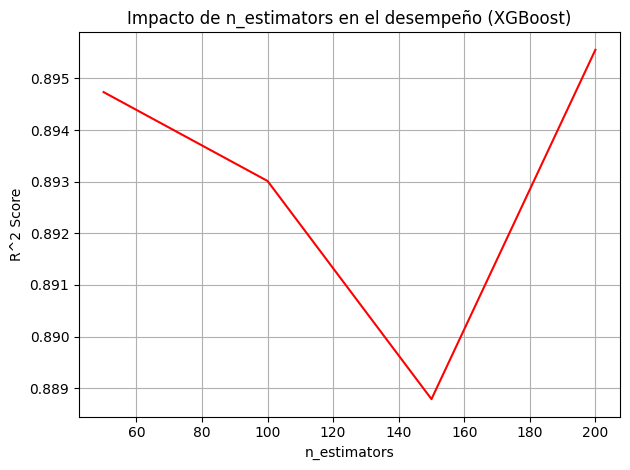

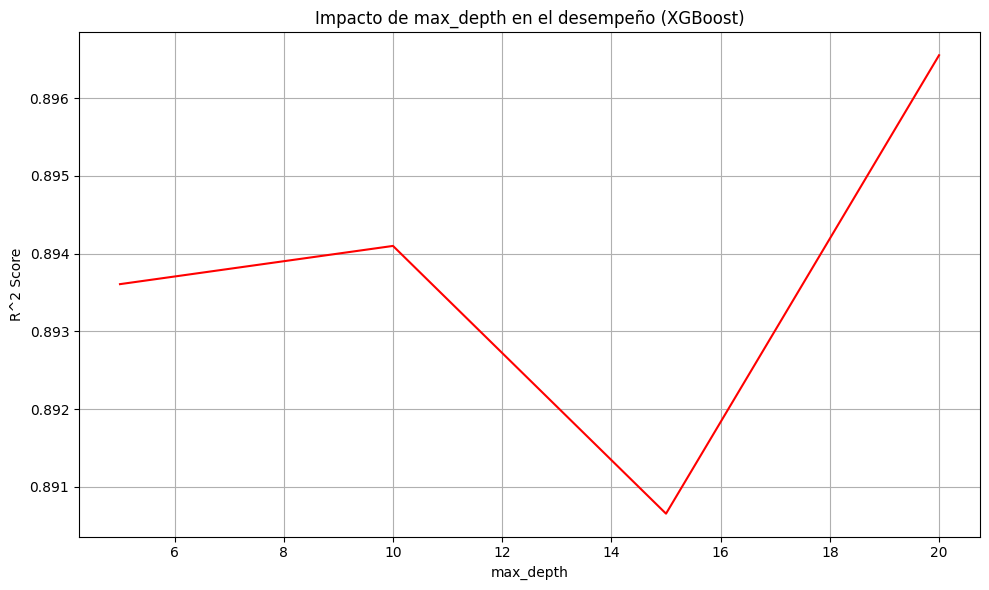

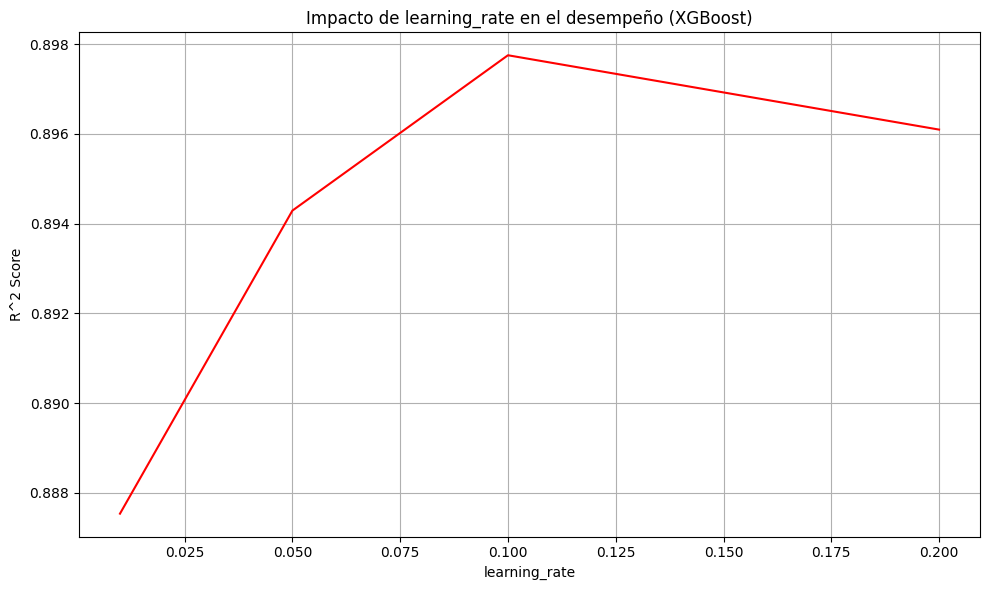

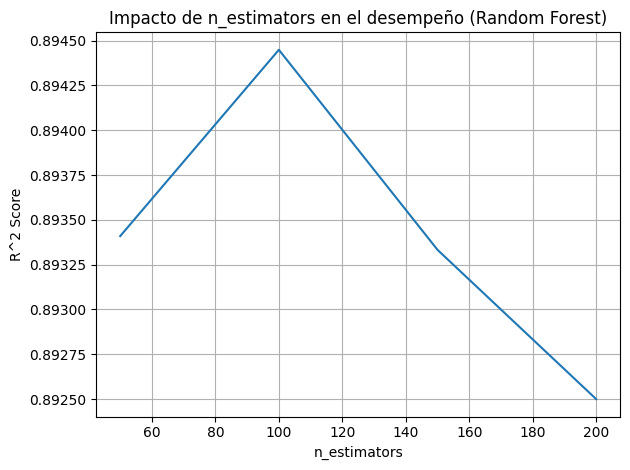

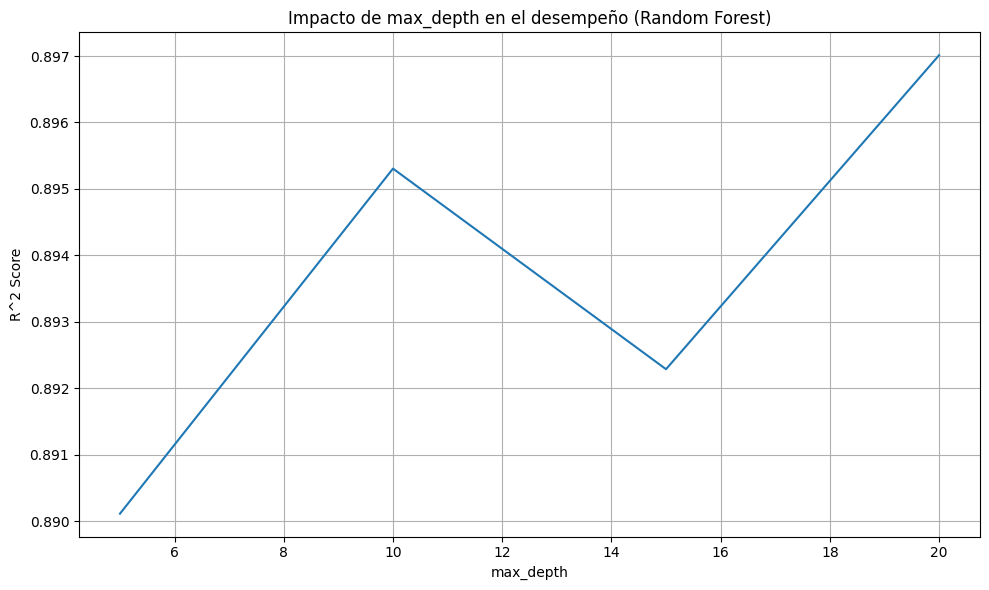

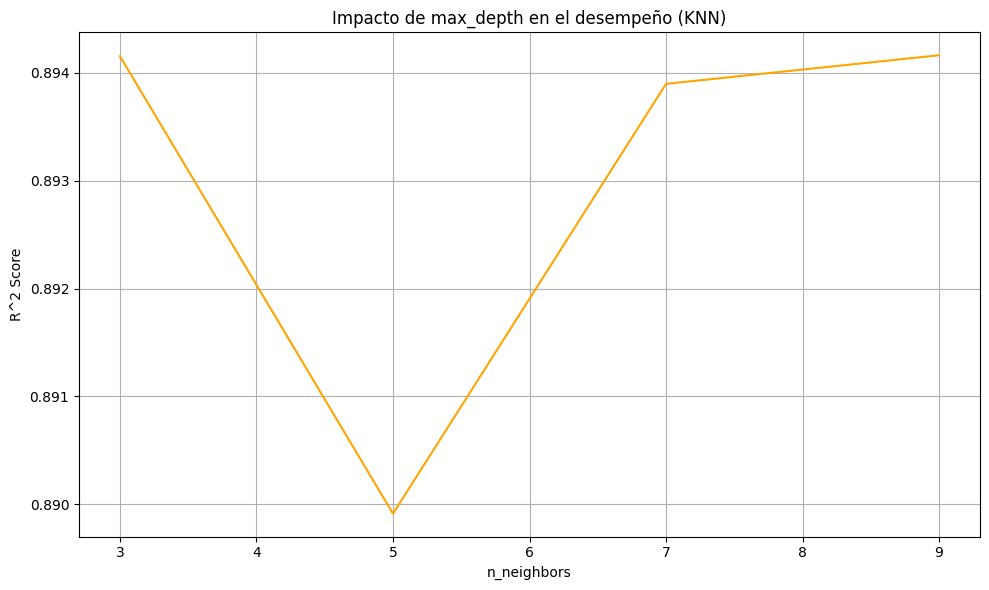

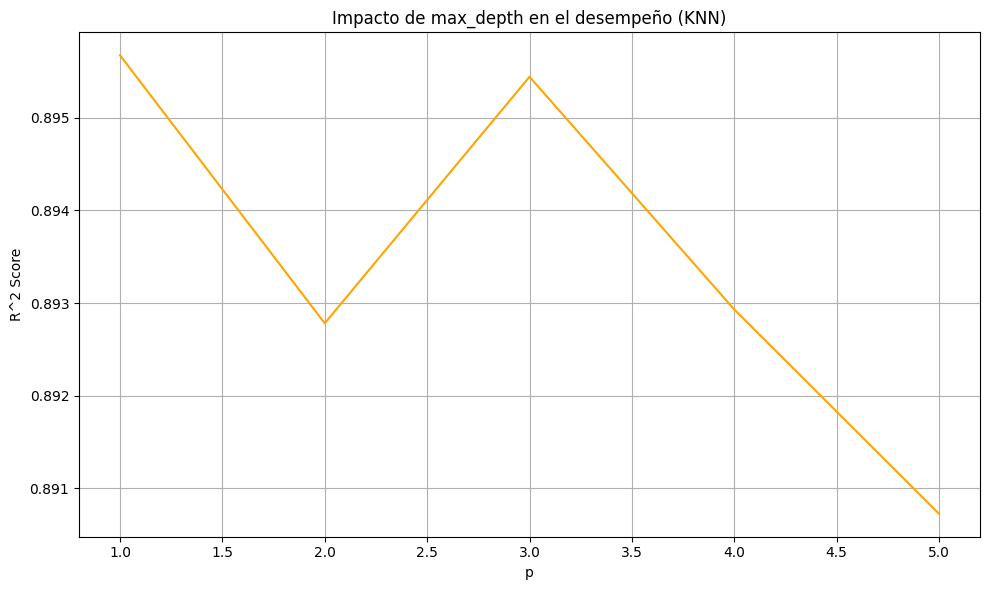

In [ ]:
# 4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__p': [1, 2, 3, 4, 5],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__max_depth': [5, 10, 15, 20],
    'xgb__n_estimators': [50, 100, 150, 200],
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__min_samples_split": [2, 5, 10, 20]
}
random_search = RandomizedSearchCV(
    estimator=build_stacking_model(),
    param_distributions=param_grid,
    scoring='r2',
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Resultados del ajuste de hiperparámetros
results = pd.DataFrame(random_search.cv_results_)

# Gráficas de la iteración de los hiperparámetros con respecto a R^2

#Para XGboost
xgb_results = results[["param_xgb__n_estimators", "param_xgb__learning_rate", "param_xgb__max_depth", "mean_test_score"]]

sns.lineplot(x="param_xgb__n_estimators", y="mean_test_score", data=xgb_results, errorbar=None, color='red')
plt.title("Impacto de n_estimators en el desempeño (XGBoost)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_xgb__max_depth", y="mean_test_score", data=xgb_results, errorbar= None, color='red')
plt.title("Impacto de max_depth en el desempeño (XGBoost)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_xgb__learning_rate", y="mean_test_score", data=xgb_results, errorbar= None,color='red')
plt.title("Impacto de learning_rate en el desempeño (XGBoost)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()


# Para Random Forest
rf_results = results[["param_rf__n_estimators", "param_rf__max_depth", "param_rf__min_samples_split", "mean_test_score"]]

# Gráfico para n_estimators
sns.lineplot(x="param_rf__n_estimators", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para max_depth vs R^2
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__max_depth", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()


# Para KNN
KNN_results = results[["param_knn__n_neighbors", "param_knn__p", "mean_test_score"]]

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_knn__n_neighbors", y="mean_test_score", data=KNN_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (KNN)")
plt.xlabel("n_neighbors")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_knn__p", y="mean_test_score", data=KNN_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (KNN)")
plt.xlabel("p")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

**5. FORMACIÓN DEL STACK**

  En esta etapa, se combinan las predicciones de los modelos base (KNN, XGboost y Random Forest) para que sirvan de entrata al meta-modelo, en este caso, una regresión lineal. El meta-modelo utiliza las predicciones de los modelos base como características para aprender a mejorar la precisión del conjunto. Esto resulta en un modelo más robusto que aprovecha las fortalezas individuales de los modelos base.

In [ ]:
# 5. FORMACIÓN DEL STACK
best_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=10,
                  estimators=[('knn', KNeighborsRegressor(n_neighbors=7, p=1)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            intera...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                              ('rf', RandomForestRegressor(max_depth=20))],
                  final_estimator=LinearRegression())

**6. PREDICCIÓN DEL STACK**

  Una vez entrenado el modelo de Stacking, se utiliza para realizar predicciones en los datos de prueba. En esta etapa, se obtienen las predicciones finales del conjunto, integrando las salidas de los modelos base con el modelo meta. Estas predicciones reflejan el desempeño conjunto de todo el modelo de Stacking.

In [ ]:
y_pred = best_model.predict(X_test_scaled)


**7. EVALUACIÓN DEL MODELO**

  La etapa de evaluación tiene como objetivo medir el rendimiento del modelo en los datos de prueba. Se utilizan métricas como el error cuadrático medio (MSE), el coeficiente de determinación (R²), el error absoluto medio (MAE) y la raíz del error cuadrático medio (RMSE) para evaluar qué tan cercanas son las predicciones a los valores reales. También se emplean visualizaciones (gráficos de dispersión y líneas) para comparar visualmente los valores reales y predichos.

  Estas etapas aseguran que el modelo final sea confiable y su desempeño sea transparente tanto estadísticamente como gráficamente.

Métricas para KNN:
  Mean Squared Error (MSE): 0.0040
  R^2 Score: 0.9068
  Mean Absolute Error (MAE): 0.0482
  Root Mean Squared Error (RMSE): 0.0632

Métricas para XGBoost:
  Mean Squared Error (MSE): 0.0030
  R^2 Score: 0.9295
  Mean Absolute Error (MAE): 0.0420
  Root Mean Squared Error (RMSE): 0.0549

Métricas para Random Forest:
  Mean Squared Error (MSE): 0.0036
  R^2 Score: 0.9165
  Mean Absolute Error (MAE): 0.0461
  Root Mean Squared Error (RMSE): 0.0598

Métricas del Stacking (Salida del Meta-modelo):
  Mean Squared Error (MSE): 0.0025
  R^2 Score: 0.9418
  Root Mean Squared Error (RMSE): 0.0499
  Mean Absolute Error (MAE): 0.0379



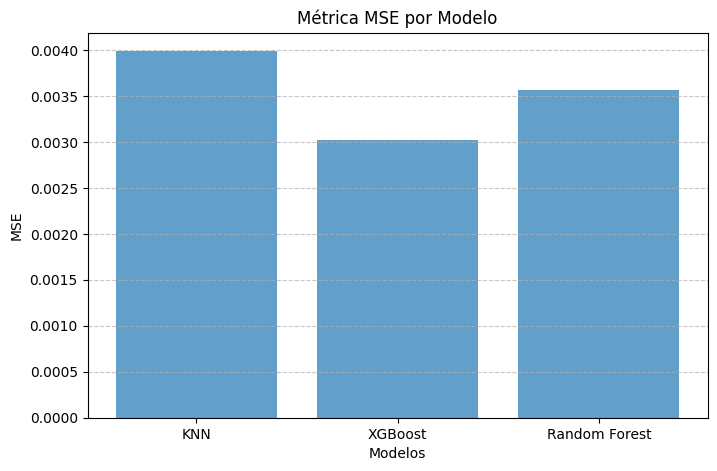

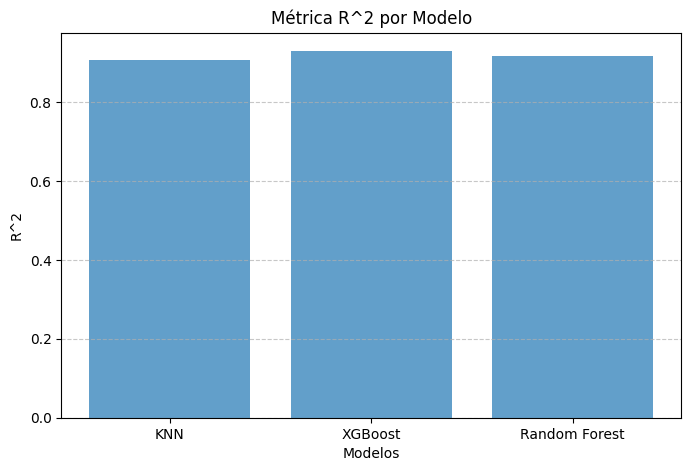

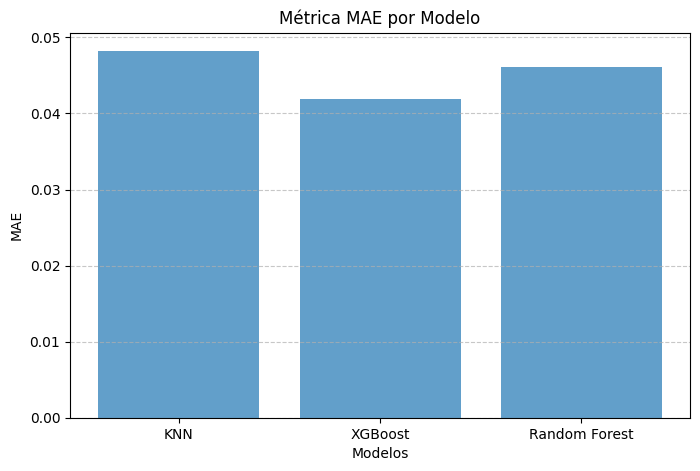

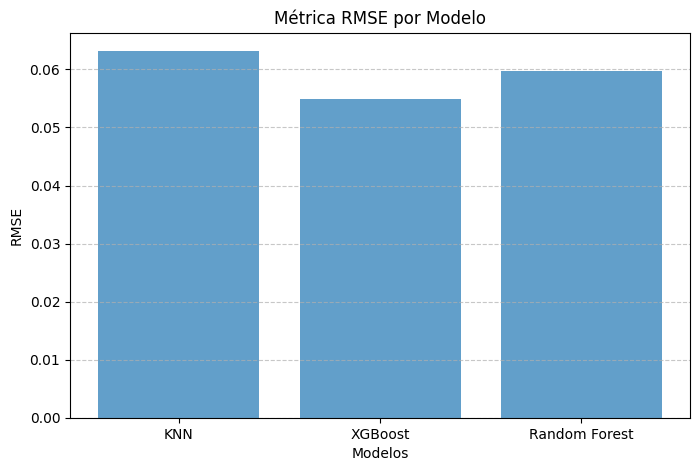

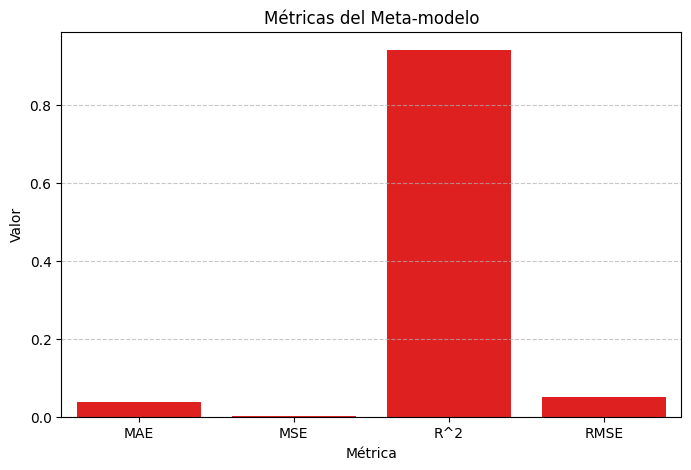


     Actual    Predicted
0       668   740.033150
1       426   532.746692
2      1876  1621.840635
3       147    57.970878
4      1466  1021.328525
..      ...          ...
108    4517  4895.430147
109    4564  4325.271744
110      33   425.156887
111    1671  2335.510981
112    8239  7839.708560

[113 rows x 2 columns]



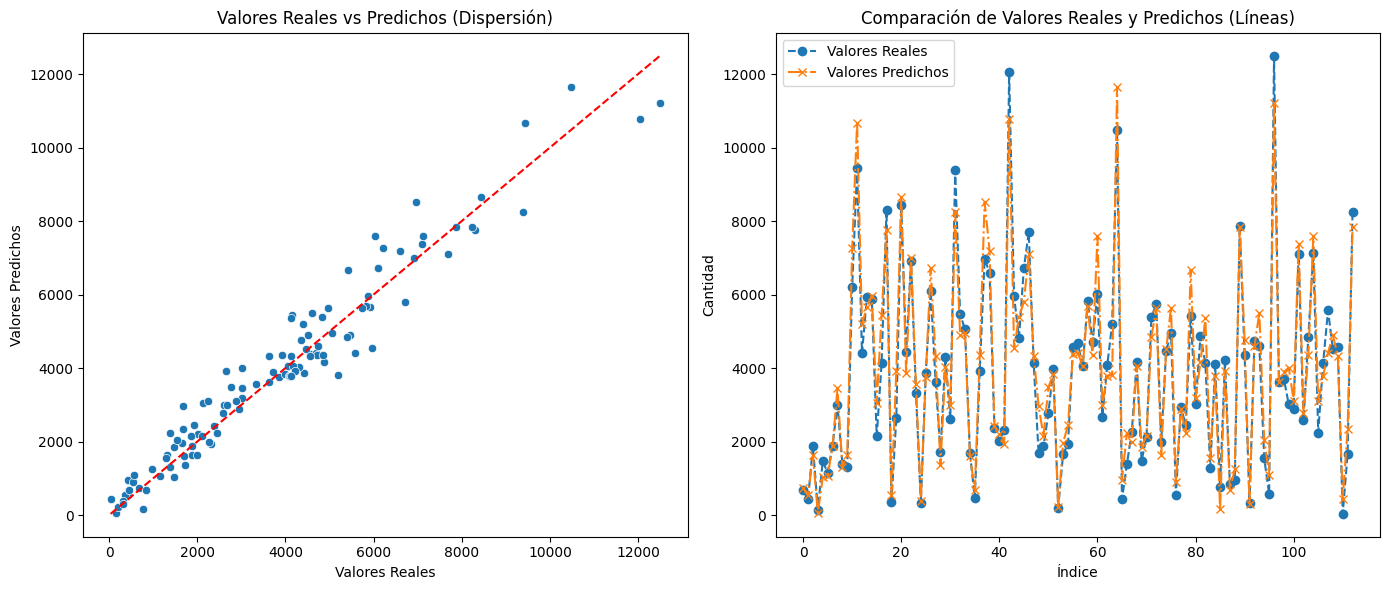

In [ ]:
# 7. EVALUACIÓN DEL MODELO

# Métricas de cada modelo base
base_models = {
    'KNN': stacking_model.named_estimators_['knn'],
    'XGBoost': stacking_model.named_estimators_['xgb'],
    'Random Forest': stacking_model.named_estimators_['rf']
}

# Calcular métricas para cada modelo base
model_metrics = {}
for model_name, model in base_models.items():
    y_pred_base = model.predict(X_test_scaled)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mse_normalizado = mse_base / ((y_test.max() - y_test.min())**2)
    r2_base = r2_score(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)
    mae_normalizado = mae_base / (y_test.max() - y_test.min())
    rmse_base = np.sqrt(mse_base)
    rmse_normalizado = rmse_base / (y_test.max() - y_test.min())

    print(f"Métricas para {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse_normalizado:.4f}")
    print(f"  R^2 Score: {r2_base:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae_normalizado:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_normalizado:.4f}\n")

    model_metrics[model_name] = {
        'MSE': mse_normalizado,
        'R^2': r2_base,
        'MAE': mae_normalizado,
        'RMSE': rmse_normalizado
    }

# Métricas de evaluación de la salida del Stacking (Salida del Meta-modelo)
meta_mse = mean_squared_error(y_test, y_pred)
meta_r2 = r2_score(y_test, y_pred)
meta_mae = mean_absolute_error(y_test, y_pred)
meta_rmse = np.sqrt(meta_mse)

# Normalizar las métricas de la salida del Stacking
meta_mse_normalizado = meta_mse / ((y_test.max() - y_test.min())**2)
meta_rmse_normalizado = meta_rmse / (y_test.max() - y_test.min())
meta_mae_normalizado = meta_mae / (y_test.max() - y_test.min())
meta_metricas = {'MAE':meta_mae_normalizado, 'MSE':meta_mse_normalizado, 'R^2':meta_r2, 'RMSE':meta_rmse_normalizado}

# Mostrar las métricas del Stacking
print("Métricas del Stacking (Salida del Meta-modelo):")
print(f"  Mean Squared Error (MSE): {meta_mse_normalizado:.4f}")
print(f"  R^2 Score: {meta_r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): {meta_rmse_normalizado:.4f}")
print(f"  Mean Absolute Error (MAE): {meta_mae_normalizado:.4f}\n")


# Gráficas de las métricas de los modelos base
metrics = ['MSE', 'R^2', 'MAE', 'RMSE'] # Fixed indentation here
for metric in metrics:
    values = [model_metrics[model][metric] for model in model_metrics]
    plt.figure(figsize=(8, 5))
    plt.bar(model_metrics.keys(), values, alpha=0.7)
    plt.title(f'Métrica {metric} por Modelo')
    plt.ylabel(metric)
    plt.xlabel('Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataframe para las metricas del Stacking (Salida del meta-modelo)
meta_metricas_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R^2', 'RMSE'],
    'Valor': [meta_mae_normalizado, meta_mse_normalizado, meta_r2, meta_rmse_normalizado]
})

meta_metricas_df = pd.DataFrame(list(meta_metricas.items()), columns=['Métrica', 'Valor'])

# Graficar las metricas del Stacking
plt.figure(figsize=(8, 5))
sns.barplot(x='Métrica', y='Valor', data=meta_metricas_df, errorbar=None, color='red')
plt.title('Métricas del Meta-modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Comparar los valores reales vs predichos
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
print()
print(comparison)
print()

# Configurar las gráficas
plt.figure(figsize=(14, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=comparison['Actual'], y=comparison['Predicted'])
plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
         [comparison['Actual'].min(), comparison['Actual'].max()],
         color='red', linestyle='--')
plt.title('Valores Reales vs Predichos (Dispersión)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Gráfico de líneas
plt.subplot(1, 2, 2)
plt.plot(comparison['Actual'].values, label='Valores Reales', marker='o', linestyle='--')
plt.plot(comparison['Predicted'].values, label='Valores Predichos', marker='x', linestyle='-.')
plt.title('Comparación de Valores Reales y Predichos (Líneas)')
plt.xlabel('Índice')
plt.ylabel('Cantidad')
plt.legend()

plt.tight_layout()
plt.show()


# **PREDICCIÓN POR CADA AÑO**

     Year  Actual  Predicted      fecha         campo
12   2017    2365     2172.0 2017-01-01     SEHS ANOP
13   2017    2756     2484.0 2017-02-01     SEHS ANOP
14   2017    2689     2632.0 2017-03-01     SEHS ANOP
15   2017    4129     3795.0 2017-04-01     SEHS ANOP
16   2017    4118     4251.0 2017-05-01     SEHS ANOP
..    ...     ...        ...        ...           ...
566  2023     427      946.0 2023-08-01  SEHS-CENTRAL
567  2023     571     1119.0 2023-09-01  SEHS-CENTRAL
568  2023    1044     1017.0 2023-10-01  SEHS-CENTRAL
569  2023    1098     1112.0 2023-11-01  SEHS-CENTRAL
570  2023     666      958.0 2023-12-01  SEHS-CENTRAL

[494 rows x 5 columns]
    Year         campo  Actual  Predicted
0   2017     SEHS ANOP  5056.0     4975.0
1   2017     SEHS APCE  7348.0     7562.0
2   2017    SEHS MICOP  4278.0     4195.0
3   2017      SEHS MNO  3364.0     3232.0
4   2017      SEHS MPN  2850.0     3135.0
5   2017  SEHS-CENTRAL  2801.0     2556.0
6   2018     SEHS ANOP  5232.0    

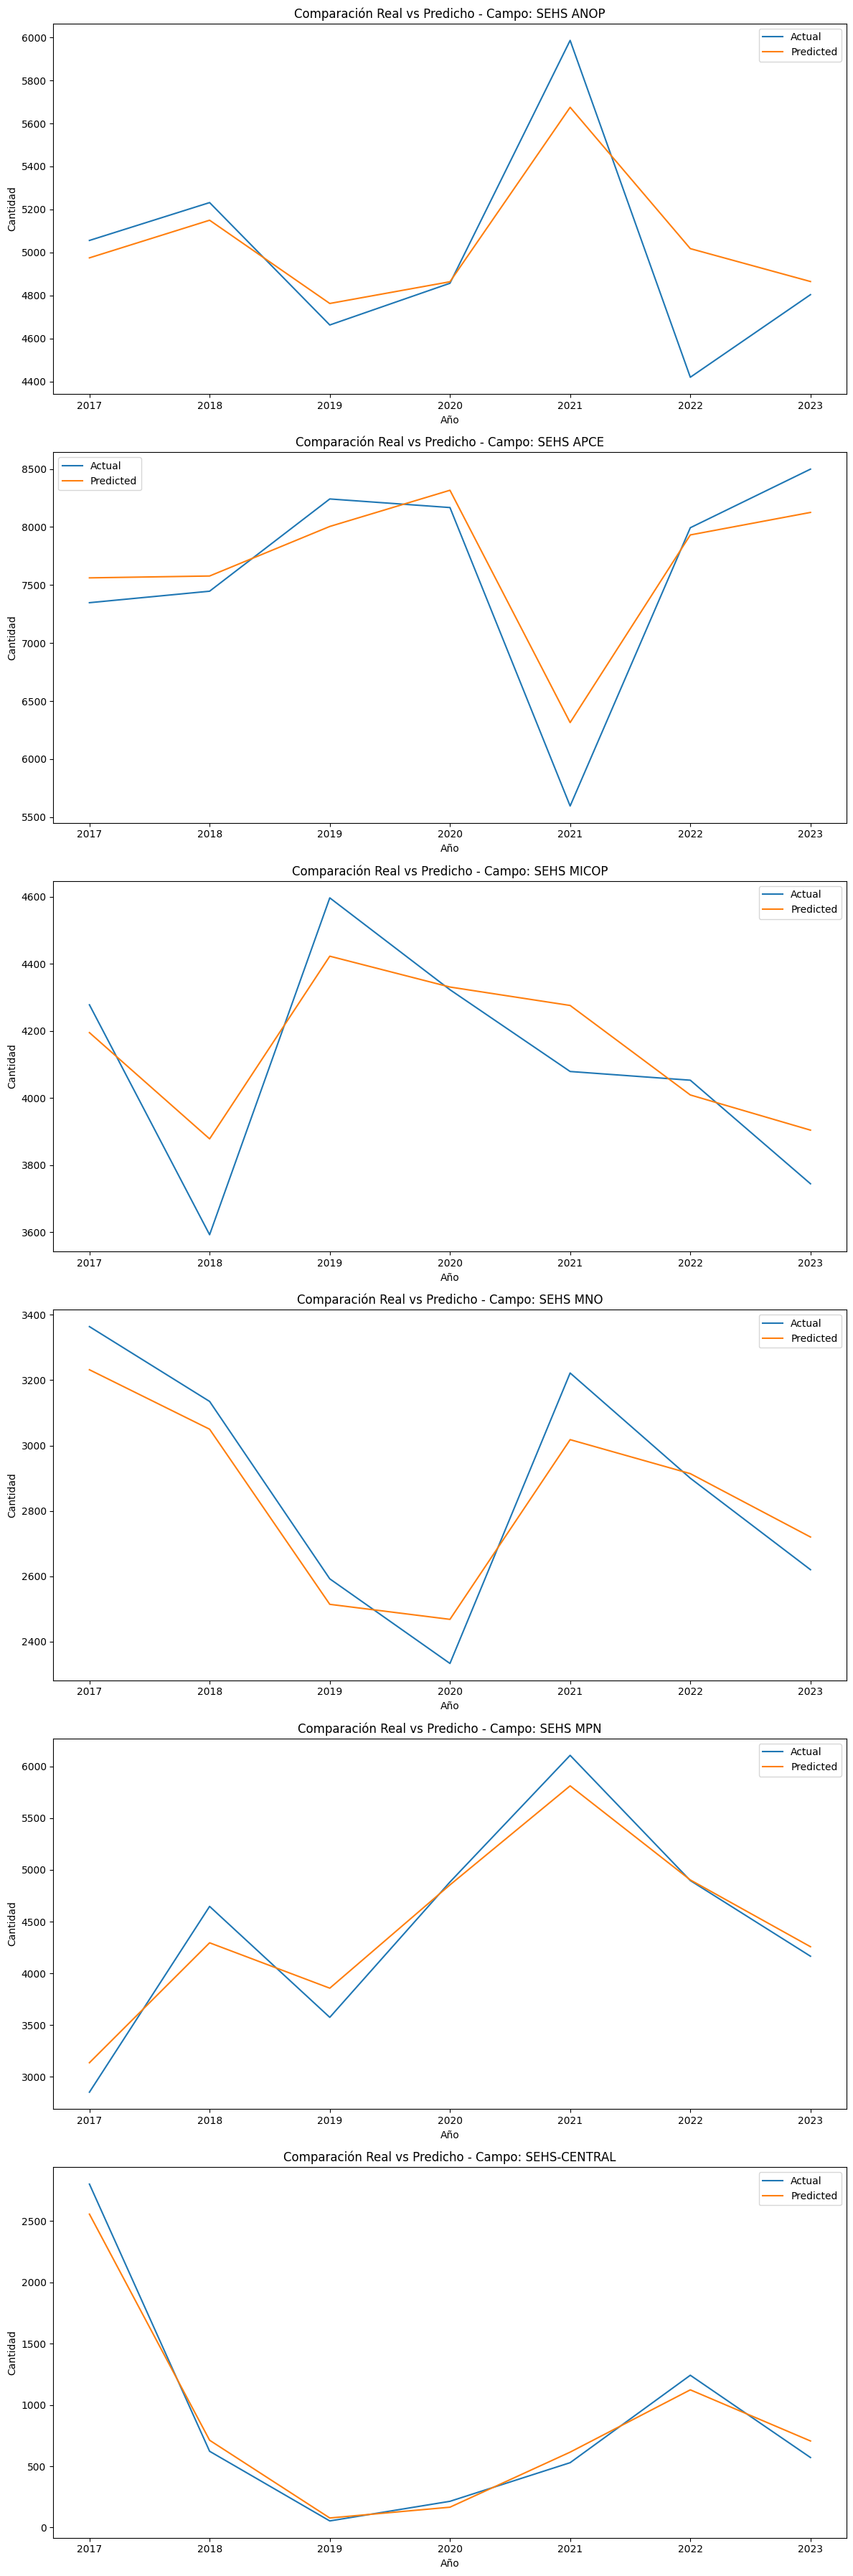

In [ ]:
df_test['campo_Original'] = None

campos_cols = [col for col in df_test.columns if col.startswith('campo_')]

for idx, row in df_test.iterrows():
    for col in campos_cols:
        if row[col] == 1:
            df_test.at[idx, 'campo_Original'] = col.replace('campo_', '')
            break

df_sum_campo['campo_Original'] = df_sum_campo['campo']

years = range(2017, 2024)
comparison_results = []

for year in years:
    df_year = df_encoded[df_encoded['Year'] == year]
    X_test = df_year.drop(columns=['cantidad', 'fecha'])
    y_test = df_year['cantidad']

    # Escalar datos de prueba
    X_test_scaled = scaler.transform(X_test)
    y_pred = stacking_model.predict(X_test_scaled)

    # Almacenar resultados
    comparison = pd.DataFrame({
        'Year': [year] * len(y_test),
        'Actual': y_test,
        'Predicted': y_pred
    })
    comparison = pd.merge(comparison, df_sum_campo[df_sum_campo['fecha'].dt.year == year][['fecha','campo']], left_index=True, right_index=True, how='left')
    comparison_results.append(comparison)

# Unir todos los resultados
final_comparison = pd.concat(comparison_results).round(0)
print(final_comparison)

final_comparison.to_excel('predicciones_comparacion_abastecimiento1.xlsx', index=False)

# Calcular cantidad promedio real y predicha por año y campo
avg_comparison = final_comparison.groupby(['Year', 'campo']).agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index().round(0)

print(avg_comparison)

# Graficar comparaciones por año y campo
campos = df_sum_campo['campo'].unique()
fig, axes = plt.subplots(nrows=len(campos), figsize=(12, 6 * len(campos)))

for i, campo in enumerate(campos):
    campo_data = avg_comparison[avg_comparison['campo'] == campo]

    sns.lineplot(data=campo_data, x='Year', y='Actual', label='Actual', ax=axes[i], errorbar=None)
    sns.lineplot(data=campo_data, x='Year', y='Predicted', label='Predicted', ax=axes[i], errorbar=None)

    axes[i].set_title(f'Comparación Real vs Predicho - Campo: {campo}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

# **PREDICCIÓN PARA EL AÑO 2024**

        fecha  cantidad_predicha
0  2024-01-01        1864.672289
1  2024-02-01        2103.303444
2  2024-03-01        2240.306657
3  2024-04-01        3449.893174
4  2024-05-01        4325.271744
..        ...                ...
67 2024-08-01         959.416536
68 2024-09-01        1095.625660
69 2024-10-01        1026.029921
70 2024-11-01        1096.394476
71 2024-12-01         823.348581

[72 rows x 2 columns]


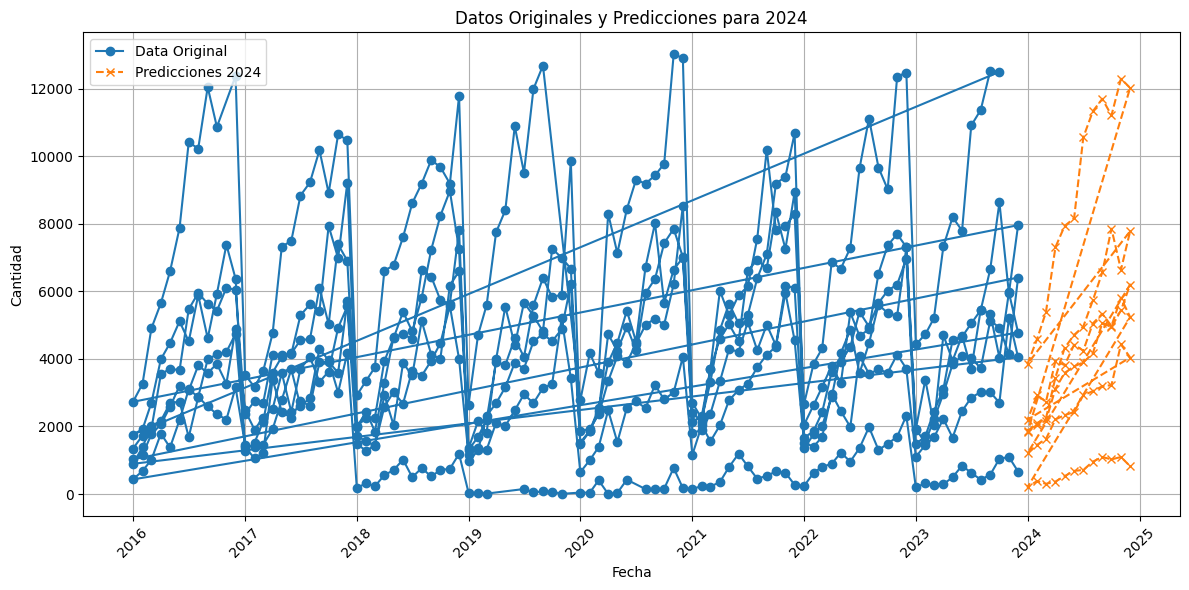

In [ ]:
# Crear datos futuros para el año 2024
unique_campos = df_sum_campo['campo'].unique()
future_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# Crear una lista para almacenar los datos futuros de cada 'campo'
all_future_data = []

# Iterar a través de cada 'campo' único para crear datos para 2024
for campo in unique_campos:
    future_data = pd.DataFrame({
        'fecha': pd.to_datetime(future_dates),
        'Year': future_dates.year,
        'Month': future_dates.month,
        'campo': campo
    })
    all_future_data.append(future_data)

# Concatenar todos los datos futuros en un solo DataFrame
future_data = pd.concat(all_future_data, ignore_index=True)

# Obtener las columnas originales utilizadas durante el entrenamiento (asumiendo que se utilizó X_train_scaled)
original_columns = X_train.columns

# Crear variables dummy para la columna 'campo' y alinearlas con las columnas originales
future_data = pd.get_dummies(future_data, columns=['campo'], prefix=['campo'], prefix_sep='_')

# Asegurarse de que future_data tenga las mismas columnas que los datos originales
missing_cols = set(original_columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0  # Agregar las columnas faltantes y rellenarlas con ceros

# Reordenar las columnas para que coincidan con las columnas originales, manteniendo 'fecha'
future_data_reordered = future_data[original_columns] # Seleccionar columnas para el modelo
future_data['cantidad_predicha'] = best_model.predict(scaler.transform(future_data_reordered))
future_results = future_data[['fecha', 'cantidad_predicha']]


# Mostrar las predicciones
print(future_results)

# Concatenar data original con predicciones para graficar
historical_data = df_sum_campo[['fecha', 'cantidad']].rename(columns={'cantidad': 'cantidad_real'})
combined_data = pd.concat([
    historical_data,
    future_results.rename(columns={'cantidad_predicha': 'cantidad_real'})
])

# Graficar data original y predicciones
plt.figure(figsize=(12, 6))
plt.plot(historical_data['fecha'], historical_data['cantidad_real'], label='Data Original', marker='o', linestyle='-')
plt.plot(future_results['fecha'], future_results['cantidad_predicha'], label='Predicciones 2024', marker='x', linestyle='--')
plt.title('Datos Originales y Predicciones para 2024')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()